In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

c:\ProgramData\anaconda3\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


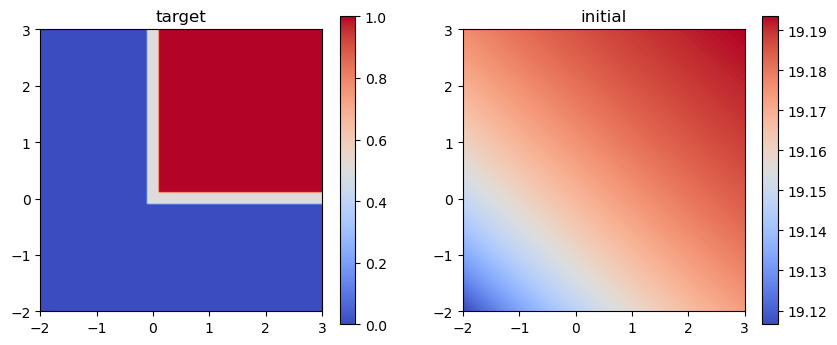

In [2]:
n = 100
h = torch.linspace(-2, 3, n)
X, Y = torch.meshgrid(h, h)
x = torch.stack((X, Y), dim=-1).reshape(-1, 2)

def plot(Z, title=""):
    plt.imshow(Z, extent=(-2, 3, -2, 3), origin='lower', cmap='coolwarm')
    plt.colorbar()
    plt.title(title)

def target(x, eps=0.1):
    x, y = x.T
    t1 = (x > eps) * (y > eps)
    t2 = (x > -eps) * (y > -eps)
    return (t1.float()+t2.float())/2

class MonoLinear(nn.Module):
    def __init__(self, in_dim, out_dim, weight_activation='identity'):
        super().__init__()
        self.w_act, self.w_act_inv = {
            'identity': (lambda x: x, lambda x: x),
            'abs': (torch.abs, torch.abs),
            "square": (torch.square, torch.sqrt),
            "exp": (torch.exp, lambda x:torch.log(x.abs())),
        }[weight_activation]
        self.W = nn.Parameter(self.mono_init_w(in_dim, out_dim, self.w_act_inv))
        self.b = nn.Parameter(torch.zeros(out_dim))
        
    @staticmethod
    def mono_init_w(in_dim, out_dim, w_act_inv):
        xav_scale = (2/ (in_dim + out_dim)) ** 0.5
        W = xav_scale * torch.randn((in_dim, out_dim))
        return w_act_inv(W)    

    def forward(self, x):
        W = self.w_act(self.W)
        x = x @ W + self.b
        return x

class LearnAct(nn.Module):
    def __init__(self, act, dim):
        super().__init__()
        self.act = act
        self.a = nn.Parameter(torch.randn(dim))

    def forward(self, x):
        a = torch.sigmoid(self.a)
        return a * self.act(x) + (1-a) * (-self.act(-x))

dim = 256
model = nn.Sequential(
    MonoLinear(2, dim, weight_activation='exp'),
    nn.Sigmoid(),#LearnAct(torch.celu, dim),
    MonoLinear(dim, dim, weight_activation='exp'),
    nn.Sigmoid(),#LearnAct(torch.celu, dim),
    MonoLinear(dim, 1, weight_activation='exp'),
)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plot(target(x).reshape(n, n), 'target')
plt.subplot(122)
plot(model(x).detach().reshape(n, n), 'initial')

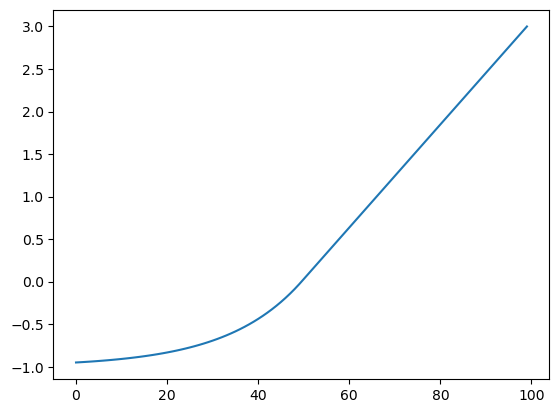

In [5]:
plt.plot(torch.celu(torch.linspace(-3, 3, 100)))

In [3]:
losses = []
z = torch.randn(1000, 2)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
for i in (pbar:=tqdm(range(10000))):
    loss = ((model(z)- target(x))**2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    pbar.set_postfix({'rmse': loss.item()**0.5})
    losses.append(loss.item())

  0%|          | 0/10000 [00:00<?, ?it/s]

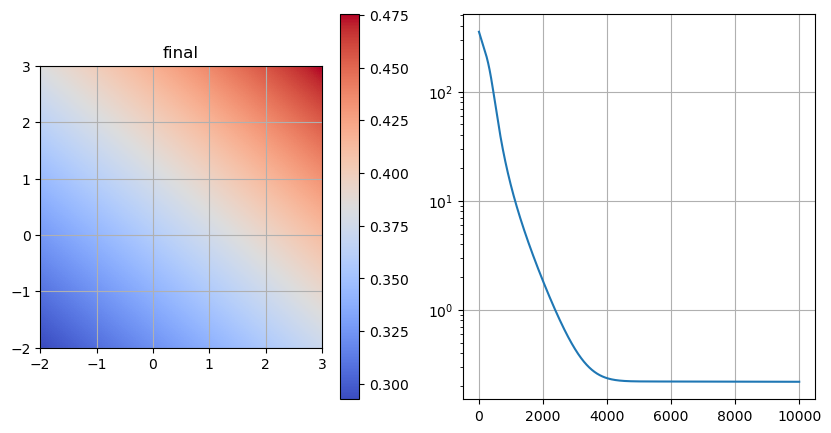

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot(model(x).detach().reshape(n, n), 'final')
plt.grid()
plt.subplot(122)
plt.semilogy(losses)
plt.grid()
plt.show()